# R script

*** 

## 1. Load files

In [2]:
# Human protein coding mRNA GENCODE v30 information
mRNA <- read.csv('../01_Resources/References/gencode.v30.pc_mRNA_transcripts_major_compact.txt',sep = '\t',header = T) #18607
# Modify ensebl gene id of mRNA
mRNA[1] <- apply(mRNA[1],1,function(x) {strsplit(x, split='.', fixed=TRUE)[[1]][1]})

# Two raw datasets
APEX = read.csv('../01_Resources/Resources/2019_CELL_APEXSeq.tsv',sep ='\t', header = T) # 3335 RNAs
Cefra = read.csv('../01_Resources/Resources/2018_CeFra_Seq_polyA_plus.tsv',sep = '\t',header = T) # 63677 RNAs

***

## 2. Data processing

- APEX-Seq

In [6]:
# Select human mRNAs 
APEX = APEX[which(APEX$Ensembl_Gene %in% mRNA$ensembl_gene_id),] # 3026

# For APEX (as mentioned in the original article, log fd > 0.75 is considered for enrichment)
# Collapsed 8 loc into binary loc
Nuc=vector(); Cyto=vector()
for (i in c(1:nrow(APEX))) {
  if (APEX[i,'Nucleus_log2FC']>0.75) {Nuc[i] = 1}
  else if (APEX[i,'Nucleolus_log2FC']>0.75) {Nuc[i] = 1}
  else if (APEX[i,'Lamina_log2FC']>0.75) {Nuc[i] = 1}
  else if (APEX[i,'Nuclear_Pore_log2FC']>0.75) {Nuc[i] = 1}
  else {Nuc[i] = 0}
  if (APEX[i,'Cytosol_log2FC']>0.75) {Cyto[i] = 1}
  else if (APEX[i,'ERM_log2FC']>0.75) {Cyto[i] = 1}
  else if (APEX[i,'OMM_log2FC']>0.75) {Cyto[i] = 1}
  else if (APEX[i,'ER_Lumen_log2FC']>0.75) {Cyto[i] = 1}
  else {Cyto[i] = 0}
}
APEX_loc <- as.data.frame(cbind(APEX,Nuc,Cyto)) # 62
APEX_Nuc <- as.character(APEX_loc[which(APEX_loc$Nuc == 1 & APEX_loc$Cyto == 0),'Ensembl_Gene']) # 1145 of 1759
APEX_Cyto <- as.character(APEX_loc[which(APEX_loc$Nuc == 0 & APEX_loc$Cyto == 1),'Ensembl_Gene']) # 1261 of 1875

In [7]:
nrow(APEX_loc)

[1] 3026

In [8]:
length(APEX_Nuc)

[1] 1145

In [9]:
length(APEX_Cyto)

[1] 1261

- Cefra-Seq

In [10]:
# 22414 mRNAs
Cefra <- Cefra[which(Cefra$gene_biotype %in% c("protein_coding")),]

ExpressedRNA <- function(cyto_A,cyto_B,insol_A,insol_B,membr_A,membr_B,nucl_A,nucl_B){
  exp_cyto <- (cyto_A+cyto_B)/2; exp_insol = (insol_A+insol_B)/2
  exp_membr <- (membr_A+membr_B)/2; exp_nucl = (nucl_A+nucl_B)/2
  if (exp_cyto >=1|exp_insol>=1|exp_membr>=1|exp_nucl>=1) {expressed <- 1} else{expressed <- 0}
  if (expressed == 1) {CNRCI <- max(exp_cyto,exp_insol,exp_membr)/(max(exp_cyto,exp_insol,exp_membr)+exp_nucl)} else{CNRCI<-0}
  return(list(expressed = expressed,CNRCI = CNRCI))
}

expressed = vector(); CNRCI= vector()
for (i in c(1:nrow(Cefra))) {
  result <- ExpressedRNA(Cefra[i,'cyto_A'],Cefra[i,'cyto_B'],Cefra[i,'insol_A'],Cefra[i,'insol_B'],
               Cefra[i,'membr_A'],Cefra[i,'membr_B'],Cefra[i,'nucl_A'],Cefra[i,'nucl_B'])
  expressed[i] <- result$expressed; CNRCI[i] <- result$CNRCI
}

Cefra_high <- Cefra[which(expressed == 1),] # 10783 mRNAs with high expression
CN_RCI_high <- as.data.frame(unlist(CNRCI[which(expressed == 1)]))
colnames(CN_RCI_high) <- "CN_RCI"
Cefra_high <- as.data.frame(cbind(Cefra_high,CN_RCI_high))

Cefra_Nuc = as.character(Cefra_high[which(Cefra_high$CN_RCI<0.4),'ensembl_gene_id']) # 1963
Cefra_Cyto = as.character(Cefra_high[which(Cefra_high$CN_RCI>0.8),'ensembl_gene_id']) # 2172

In [11]:
nrow(Cefra)

[1] 22414

In [12]:
nrow(Cefra_high)

[1] 10783

In [13]:
length(Cefra_Nuc)

[1] 1963

In [14]:
length(Cefra_Cyto)

[1] 2172

***
###  

## 3. Union and remove bi-localized lncRNAs 

In [15]:
# Union
Nuc_Union <- union(APEX_Nuc,Cefra_Nuc)
Cyto_Union <- union(APEX_Cyto,Cefra_Cyto)

In [16]:
# Remove bi-localized lncRNAs
Nuc_final <- as.data.frame(setdiff(Nuc_Union,Cyto_Union))
Cyto_final <- as.data.frame(setdiff(Cyto_Union,Nuc_Union))
colnames(Nuc_final) = colnames(Cyto_final) = 'ensembl_gene_id'

In [17]:
nrow(Nuc_final)

[1] 2430

In [18]:
nrow(Cyto_final)

[1] 3056

***
###  

## 4. Filter by GENCODE annotation

In [20]:
Nuc_info <- merge.data.frame(mRNA,Nuc_final,by = 'ensembl_gene_id')
Cyto_info <- merge.data.frame(mRNA,Cyto_final,by = 'ensembl_gene_id')

In [21]:
nrow(Nuc_info)

[1] 2256

In [22]:
nrow(Cyto_info)

[1] 2924

***
###  

## 5. Output

In [23]:
write.table(Nuc_info,'01_mRNA_info_nuc_gene.tsv',sep = '\t', quote = FALSE,row.names = FALSE)
write.table(Cyto_info,'01_mRNA_info_cyto_gene.tsv',sep = '\t', quote = FALSE,row.names = FALSE)

In [25]:
# Summary of sequence length
total <- rbind(Nuc_info,Cyto_info)
quantile(tapply(as.character(total$cdna),total$ensembl_gene_id,nchar),c(0,0.05,0.25,0.50,0.75,0.95,1))

0%       5%      25%      50%      75%      95%     100% 
  207.00   695.95  1623.00  2742.00  4566.25  8469.85 34626.00

In [1]:
total <- read.table('01_mRNA_info_nuc_gene.tsv',sep ='\t',header = T)

In [2]:
total$length <- tapply(as.character(total$cdna),total$ensembl_gene_id,nchar)

In [3]:
library(ggplot2)

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”


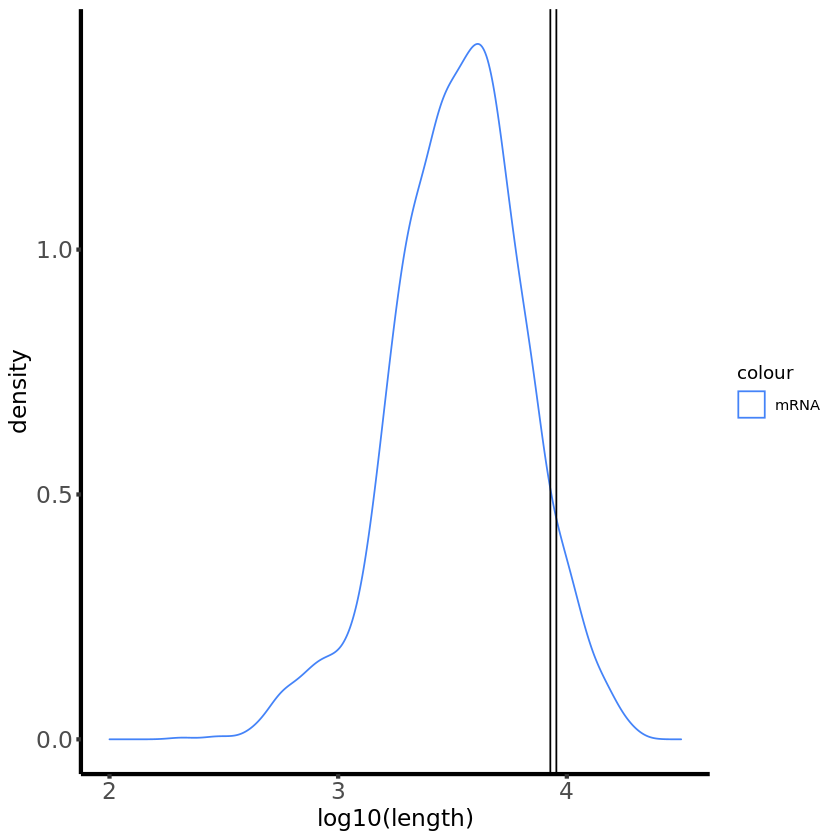

In [13]:
p_dis<- ggplot(total, aes(x=log10(length),color = "mRNA"))+
geom_density()+
geom_vline(xintercept = log10(8469.85))+
geom_vline(xintercept = log10(9000))+
scale_color_manual(values = c("#4483F8"))+
scale_x_continuous(breaks = c(2,3,4),limits = c(2,4.5))+
theme_classic()+
theme(axis.text = element_text(size=14),
      axis.title = element_text(size=14),
      element_line(size = 1.2))
ggsave("./01_mRNA_length_distribution_with_text.pdf", p_dis, width = 10, height = 10) 
p_dis

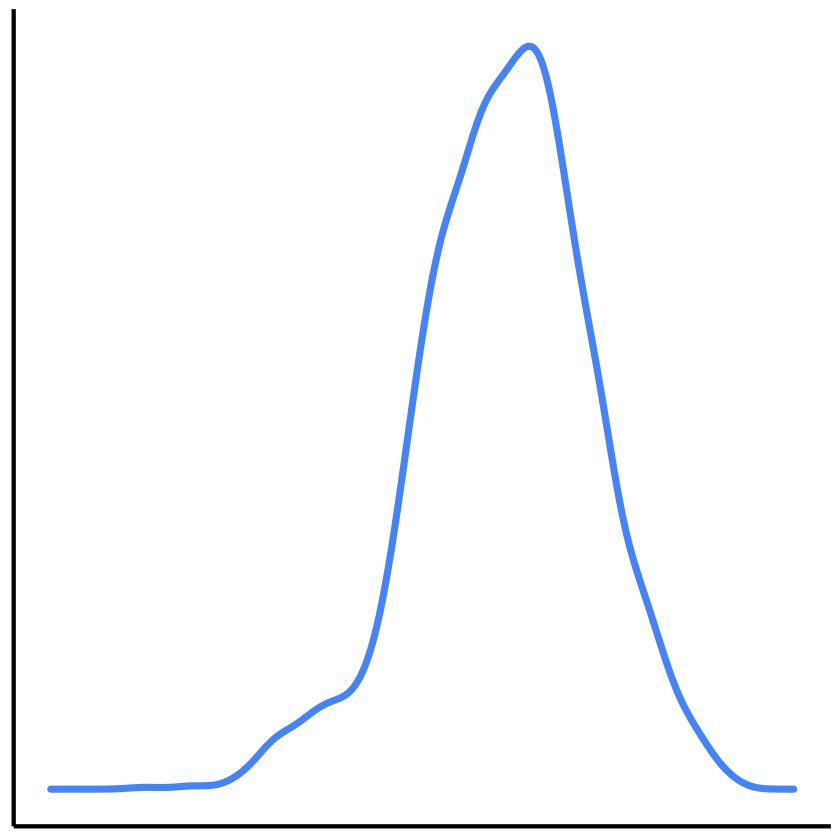

In [15]:
p_dis_blank<- ggplot(total, aes(x=log10(length),color = "mRNA"))+
geom_density(size = 2)+
scale_color_manual(values = c("#4483F8"))+
scale_x_continuous(breaks = c(2,3,4),limits = c(2,4.5))+
theme_classic()+
theme(axis.text = element_text(size=14),
      axis.title = element_text(size=14),
      element_line(size = 1.2))+
theme(axis.text = element_blank(),axis.title = element_blank(),axis.ticks = element_blank(),legend.position = "None")
ggsave("./01_lncRNA_length_distribution.pdf", p_dis_blank, width = 10, height = 10) 
p_dis_blank